**Reference**:

https://towardsdatascience.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface-94b2ed6f798f

https://predictivehacks.com/how-to-fine-tune-an-nlp-regression-model-with-transformers-and-huggingface/


# Don't normalize the data 

# Linear Regression 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from datasets import Dataset,load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers.utils import logging
logging.set_verbosity_error()
pd.set_option('display.max_colwidth', None)

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer


In [27]:
! pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/yousef/code/thesis-nlp/code-wip-dataset


In [28]:

data_file = '/Users/yousef/code/thesis-nlp/dataset/incident-ohlc-v06-scalar.csv'
df_o = pd.read_csv(data_file,parse_dates=['date'],index_col=['date'])
df_o.sort_index(inplace=True)
# df['date'] = df.index
# data_columns =  ['w_open', 'w_high', 'w_low', 'w_close', 'new', 'started','done', 'dayofweek', 'dayofmonth', 'dayofyear', 'target', 'y_ystrdy']
data_columns =  ['w_open', 'w_high', 'w_low', 'w_close', 'new', 'started','done', 'dayofweek', 'dayofmonth', 'dayofyear', 'target', 'y_ystrdy']

df_o = df_o[data_columns].copy()
max_number_in_data = int(df_o.describe().transpose()["max"].max())
print(f'Max number in the data is {max_number_in_data}')
# display(df.head())
df = pd.DataFrame()
df['label']= df_o['target']
df['text']= ''
for col in data_columns[:-2]:
    df_o[col] = df_o[col].apply(lambda x: f'{x:.0f}')
    df['text'] = df['text'] + f' {col} ' + df_o[col].astype(str)

# Remove NaN
df = df.iloc[1:-1]

display(df['text'][0])
display(df.head(2))


Max number in the data is 366


' w_open 0 w_high 1 w_low 0 w_close 1 new 3 started 1 done 0 dayofweek 3 dayofmonth 14 dayofyear 14'

,label,text
date,,
2010-01-14,1.0,w_open 0 w_high 1 w_low 0 w_close 1 new 3 started 1 done 0 dayofweek 3 dayofmonth 14 dayofyear 14
2010-01-15,1.0,w_open 1 w_high 1 w_low 1 w_close 1 new 1 started 0 done 0 dayofweek 4 dayofmonth 15 dayofyear 15


In [29]:
df['label']

date
2010-01-14     1.0
2010-01-15     1.0
2010-01-16     1.0
2010-01-17     2.0
2010-01-18     3.0
              ... 
2013-12-29    33.0
2013-12-30    30.0
2013-12-31    26.0
2014-01-01    21.0
2014-01-02    13.0
Name: label, Length: 1450, dtype: float64

In [30]:
df_o

,w_open,w_high,w_low,w_close,new,started,done,dayofweek,dayofmonth,dayofyear,target,y_ystrdy
date,,,,,,,,,,,,
2010-01-13,0,0,0,0,5,0,0,2,13,13,1.0,NaN
2010-01-14,0,1,0,1,3,1,0,3,14,14,1.0,0.0
2010-01-15,1,1,1,1,1,0,0,4,15,15,1.0,2.0
2010-01-16,1,1,1,1,0,0,0,5,16,16,1.0,1.0
2010-01-17,1,1,1,1,0,0,0,6,17,17,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-30,33,33,33,33,0,0,0,0,30,364,30.0,33.0
2013-12-31,33,33,30,30,0,0,3,1,31,365,26.0,33.0
2014-01-01,30,30,26,26,0,0,4,2,1,1,21.0,27.0


## Create AutoTokenizer

In [31]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Pandas To Dataset

In [32]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler

columns = ['text','label']
def make_dataset(dataset, iloc_from, iloc_to):
    df_ = dataset[columns].iloc[iloc_from:iloc_to]  
    # df_.reset_index(inplace=True,drop=True)
    return df_

df_nlp = make_dataset(df, 0,len(df))

display(df_nlp.head(3))

dataset = Dataset.from_pandas(df_nlp[columns],preserve_index=False) 
dataset = dataset.train_test_split(test_size=0.3) 

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


,text,label
date,,
2010-01-14,w_open 0 w_high 1 w_low 0 w_close 1 new 3 started 1 done 0 dayofweek 3 dayofmonth 14 dayofyear 14,1.0
2010-01-15,w_open 1 w_high 1 w_low 1 w_close 1 new 1 started 0 done 0 dayofweek 4 dayofmonth 15 dayofyear 15,1.0
2010-01-16,w_open 1 w_high 1 w_low 1 w_close 1 new 0 started 0 done 0 dayofweek 5 dayofmonth 16 dayofyear 16,1.0


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

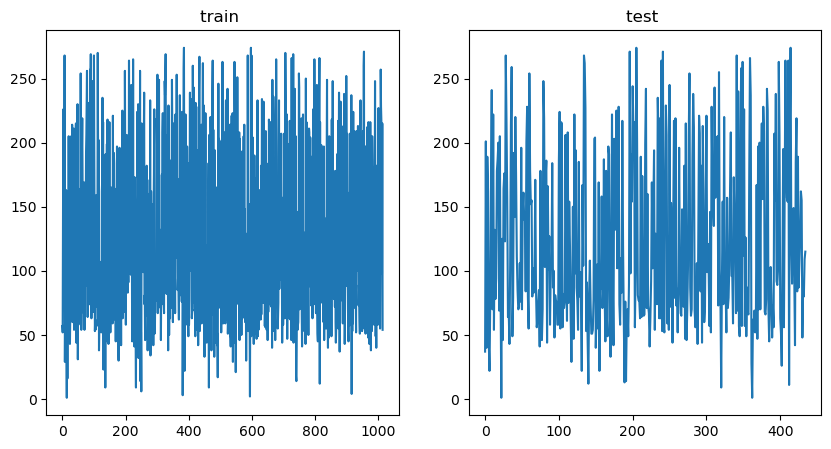

In [33]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))

axs[0].plot(dataset['train']['label'],label='train')
axs[1].plot(dataset['test']['label'],label='train')
axs[0].title.set_text('train ')
axs[1].title.set_text('test ')


## Tokenization & How To Add New Tokens


In [34]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

for x in data_columns:
    tokenizer.add_tokens(x)
    
for x in range(max_number_in_data):
    tokenizer.add_tokens(str(x))

    
        
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# add separators : , - , at, on 
# add hour, min as  00 , 01 , 59
# add 2010, 2011

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [35]:
tokens = tokenizer('3 3 2 0 done 250 done 250')['input_ids']
tokens_unique = list(set(tokens))
actual_tokens = [tokenizer.decode(i) for i in tokens]

print(f'tokens:{len(tokens)},{tokens} \ntokens_unique:{len(tokens_unique)},{tokens_unique} \nactual token:{actual_tokens}')

tokens:10,[101, 1017, 1017, 1016, 1014, 2589, 5539, 2589, 5539, 102] 
tokens_unique:7,[5539, 101, 102, 1014, 1016, 1017, 2589] 
actual token:['[CLS]', '3', '3', '2', '0', 'done', '250', 'done', '250', '[SEP]']


#### Test Tokenization

In [36]:
text = df_nlp["text"][0]
tokens = tokenizer(text)['input_ids']
tokens_unique = list(set(tokens))
actual_tokens = [tokenizer.decode(i) for i in tokens]

print(f'text  :{text} \ntokens:{tokens} \ntokens_unique:{tokens_unique} \nactual token:{actual_tokens}')

text  : w_open 0 w_high 1 w_low 0 w_close 1 new 3 started 1 done 0 dayofweek 3 dayofmonth 14 dayofyear 14 
tokens:[101, 30522, 1014, 30523, 1015, 30524, 1014, 30525, 1015, 2047, 1017, 2318, 1015, 2589, 1014, 30526, 1017, 30527, 2403, 30528, 2403, 102] 
tokens_unique:[30528, 2589, 2403, 101, 102, 2318, 30527, 1014, 1015, 1017, 30522, 30523, 30524, 30525, 30526, 2047] 
actual token:['[CLS]', 'w_open', '0', 'w_high', '1', 'w_low', '0', 'w_close', '1', 'new', '3', 'started', '1', 'done', '0', 'dayofweek', '3', 'dayofmonth', '14', 'dayofyear', '14', '[SEP]']


## Fine-Tuning The Model

In [37]:
# num_labels =1 means regression
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(output_dir="test_trainer",
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  num_train_epochs=3,
                                  save_total_limit = 2,
                                  save_strategy = 'no',
                                  load_best_model_at_end=False,
                                  report_to="none"
                                  )

### Metrics Function


In [38]:
from datasets import load_metric
from sklearn.metrics import mean_squared_error
import evaluate

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # rmse = mean_squared_error(labels, predictions, squared=False)
    rmse = mean_squared_error(labels, predictions, squared=True)
    return {"rmse": rmse}

def compute_metrics_mape(eval_pred):
    predictions, labels = eval_pred
    mape = mape_metric.compute(predictions=predictions, references=labels)
    return {"mape": mape}

### Train The Model

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics
)
trainer.train()
print('\n<===== Train is done =====>')

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/yousef/miniforge3/envs/mlp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1015
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 192
  Number of trainable parameters = 66969601
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceCl

{'loss': 19370.9238, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}
{'eval_loss': 17649.98828125, 'eval_rmse': 17649.990234375, 'eval_runtime': 52.3233, 'eval_samples_per_second': 8.314, 'eval_steps_per_second': 0.535, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 435
  Batch size = 16


{'loss': 17896.5605, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}
{'eval_loss': 16513.865234375, 'eval_rmse': 16513.8671875, 'eval_runtime': 93.5146, 'eval_samples_per_second': 4.652, 'eval_steps_per_second': 0.299, 'epoch': 2.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 435
  Batch size = 16


{'loss': 17086.2402, 'learning_rate': 0.0, 'epoch': 3.0}




Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 16112.173828125, 'eval_rmse': 16112.1728515625, 'eval_runtime': 94.9135, 'eval_samples_per_second': 4.583, 'eval_steps_per_second': 0.295, 'epoch': 3.0}
{'train_runtime': 2250.4278, 'train_samples_per_second': 1.353, 'train_steps_per_second': 0.085, 'train_loss': 18117.908203125, 'epoch': 3.0}


TrainOutput(global_step=192, training_loss=18117.908203125, metrics={'train_runtime': 2250.4278, 'train_samples_per_second': 1.353, 'train_steps_per_second': 0.085, 'train_loss': 18117.908203125, 'epoch': 3.0})

# Train and test chart and metrics

In [40]:
predictions_test = trainer.predict(tokenized_datasets["test"])
predictions_train = trainer.predict(tokenized_datasets["train"])
print('\n<===== Predictions are done =====>')

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 435
  Batch size = 16
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1015
  Batch size = 16


In [41]:
plt.plot(data[0],label='train')

NameError: name 'data' is not defined

In [ ]:
data = [predictions_train.predictions,predictions_test.predictions]
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))

axs[0].plot(data[0],label='train')
axs[0].plot(dataset["train"]['label'],label='y')
axs[0].title.set_text('train ')
axs[0].legend(loc='upper right')


axs[1].plot(data[1],label='test')
axs[1].plot(dataset["test"]['label'],label='y')
axs[1].title.set_text('test ')
axs[1].legend(loc='upper right')


In [ ]:
print(f'key\t\t train.metric \t test.metrics')

for key in list(predictions_test.metrics.keys())[:2]:
    print(f'{key} \t\t{predictions_train.metrics[key]:0.3f} \t\t{predictions_test.metrics[key]:0.3f}')

## Save And Load The Pre-Trained Model And Tokenizer


In [ ]:
# save the model/tokenizer

model.save_pretrained("model")
tokenizer.save_pretrained("tokenizer")

# load the model/tokenizer

from transformers import AutoModelForTokenClassification
model = AutoModelForSequenceClassification.from_pretrained("model")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

##  Use The Model

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True) 

def pipeline_prediction(text):
    df=pd.DataFrame({'text':[text]})
    dataset = Dataset.from_pandas(df,preserve_index=False) 
    tokenized_datasets = dataset.map(tokenize_function)
    raw_pred, _, _ = trainer.predict(tokenized_datasets) 
    return(raw_pred[0][0])

pipeline_prediction("🚨 Get 50% now!")